Merge peaks generated by scE2G pipeline for 5 super groups, and make enhancer-gene pairs (dist < 1M)

In [1]:
library(Seurat)
library(Signac)
library(magrittr)
library(genomation)
library(GenomicRanges)
library(Matrix)
library(ggplot2)

Loading required package: SeuratObject

Loading required package: sp

‘SeuratObject’ was built under R 4.3.2 but the current version is
4.3.3; it is recomended that you reinstall ‘SeuratObject’ as the ABI
for R may have changed

‘SeuratObject’ was built with package ‘Matrix’ 1.6.3 but the current
version is 1.6.5; it is recomended that you reinstall ‘SeuratObject’ as
the ABI for ‘Matrix’ may have changed


Attaching package: ‘SeuratObject’


The following object is masked from ‘package:base’:

    intersect


Loading required package: grid

Warning message:
“replacing previous import ‘Biostrings::pattern’ by ‘grid::pattern’ when loading ‘genomation’”
Loading required package: stats4

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following object is masked from ‘package:SeuratObject’:

    intersect


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDupl

Specify file path

In [2]:
dir.scE2G_res = "/maps/projects/ralab_nnfc-AUDIT/people/lpm537/software/scE2G_pipeline/240508/sc-E2G/test/results_BMMC5/"
path.obj.seurat = "/maps/projects/ralab_nnfc-AUDIT/people/lpm537/project/E2G/analysis/E2G_240503/data/BMMC/1.prepare_data/2.seurat_pipeline.240506/obj.seurat.rds"
dir.output = "/maps/projects/ralab_nnfc-AUDIT/people/lpm537/project/E2G/analysis/E2G_240503/data/BMMC/1.prepare_data/5.merge_peaks_from_5_super_groups.240524/"

In [3]:
dir.create(dir.output,recursive = T)

Import seurat object

In [4]:
obj.seurat = readRDS(path.obj.seurat)

In [5]:
obj.seurat$cell_type.merged = NA
obj.seurat@meta.data[obj.seurat$cell_type.rename %in% c("CD4_pos_T_activated",
                                                        "CD4_pos_T_naive",
                                                        "CD8_pos_T",
                                                        "CD8_pos_T_naive"),
                     "cell_type.merged"] = "T"
obj.seurat@meta.data[obj.seurat$cell_type.rename %in% c("Transitional_B",
                                                        "B1_B",
                                                        "Naive_CD20_pos_B"),
                     "cell_type.merged"] = "B"
obj.seurat@meta.data[obj.seurat$cell_type.rename %in% c("CD14_pos_Mono",
                                                        "CD16_pos_Mono",
                                                        "ID2_hi_myeloid_prog",
                                                        "G_M_prog"),
                     "cell_type.merged"] = "Myeloid"
obj.seurat@meta.data[obj.seurat$cell_type.rename %in% c("cDC2",
                                                        "pDC"),
                     "cell_type.merged"] = "Dendritic"
obj.seurat@meta.data[obj.seurat$cell_type.rename %in% c("Erythroblast",
                                                        "Normoblast",
                                                        "Proerythroblast"),
                     "cell_type.merged"] = "Erythroid"
table(obj.seurat$cell_type.merged)


        B Dendritic Erythroid   Myeloid         T 
     9752      2050      8996     14048     22525 

Import E-G pairs for each cluster

In [7]:
list.pairs.E2G = list()
for (cell_type.tmp in c("B","Myeloid","T","Erythroid","Dendritic")){
    list.pairs.E2G[[cell_type.tmp]] = readGeneric(paste(dir.scE2G_res,cell_type.tmp,"Kendall","Pairs.tsv.gz",sep = "/"),
                                                  header = T,
                                                  keep.all.metadata = T)


}

In [9]:
list.ABC.1M = list()
for (cell_type.tmp in c("B","Myeloid","T","Erythroid","Dendritic")){
    bed.tmp = readGeneric(paste(dir.scE2G_res,cell_type.tmp,"Predictions","EnhancerPredictionsAllPutative.tsv.gz",sep = "/"),
                                            header = T,
                                            keep.all.metadata = T)
    list.ABC.1M[[cell_type.tmp]] = bed.tmp[bed.tmp$distance < 10^6]
    rm(bed.tmp)
}

Check peak width

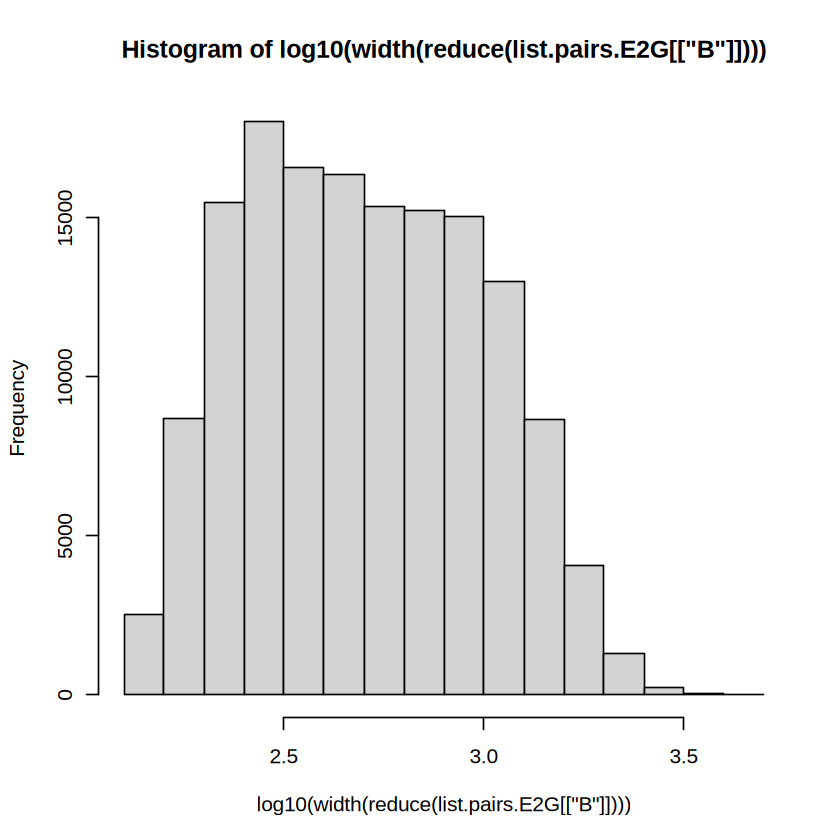

In [10]:
hist(log10(width(reduce(list.pairs.E2G[["B"]]))))

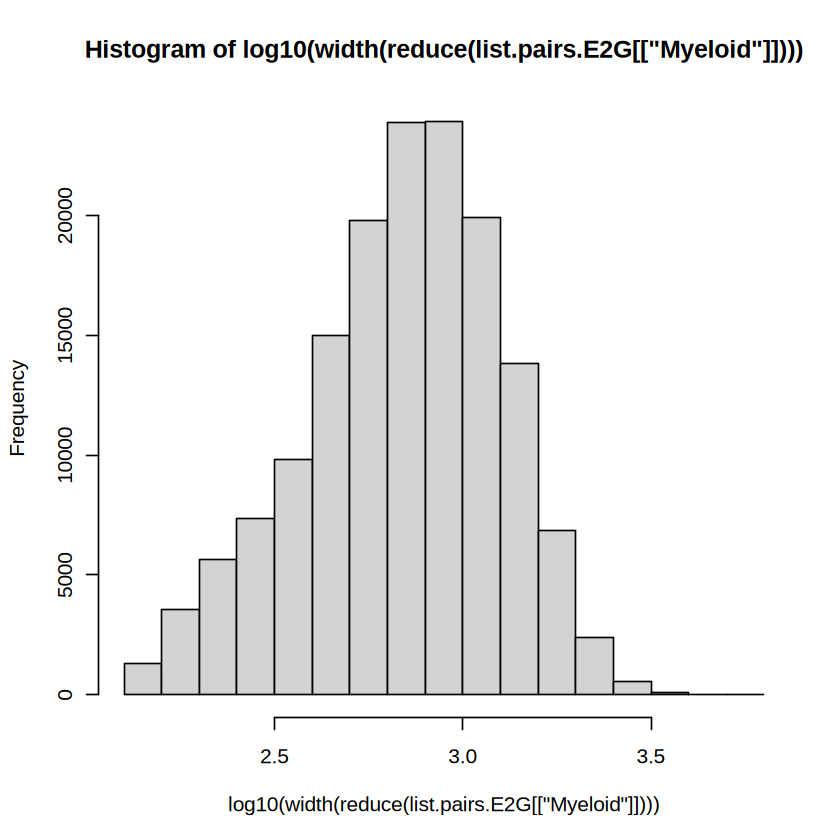

In [11]:
hist(log10(width(reduce(list.pairs.E2G[["Myeloid"]]))))

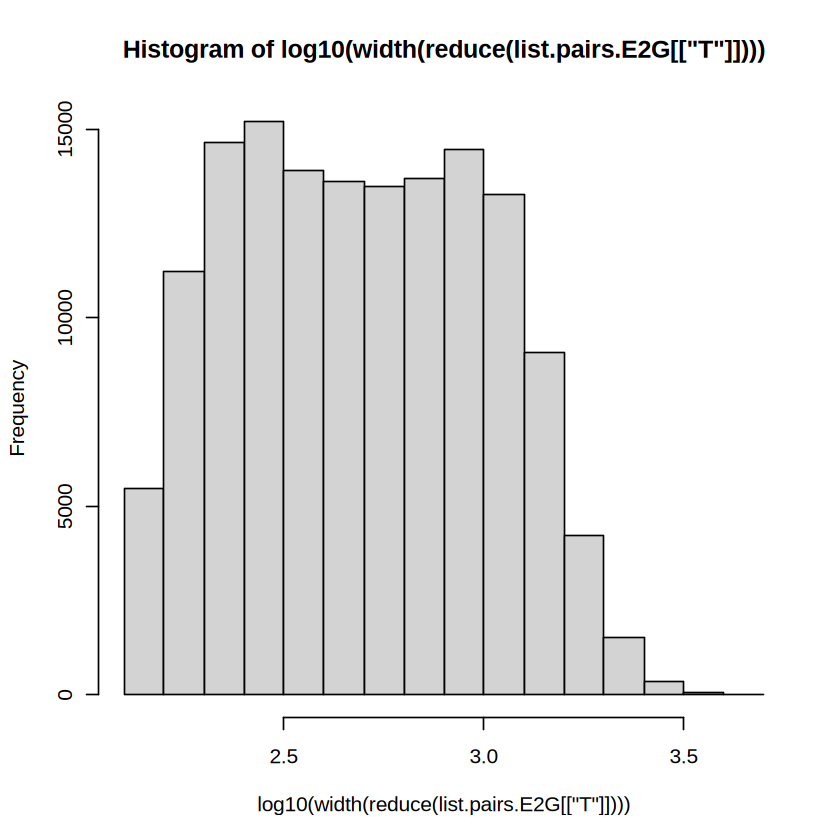

In [12]:
hist(log10(width(reduce(list.pairs.E2G[["T"]]))))

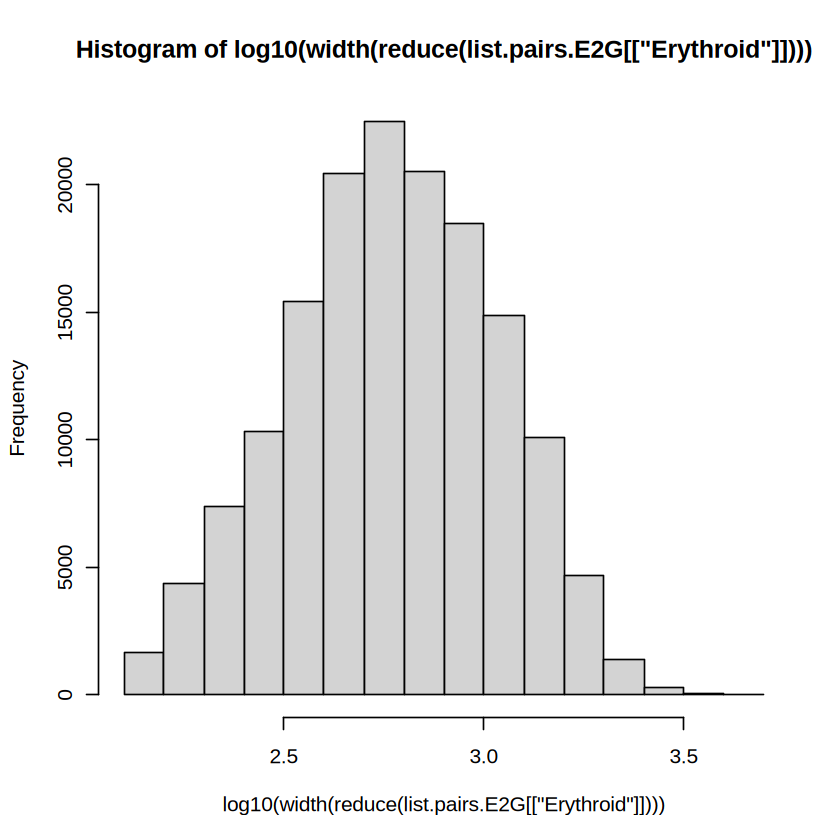

In [13]:
hist(log10(width(reduce(list.pairs.E2G[["Erythroid"]]))))

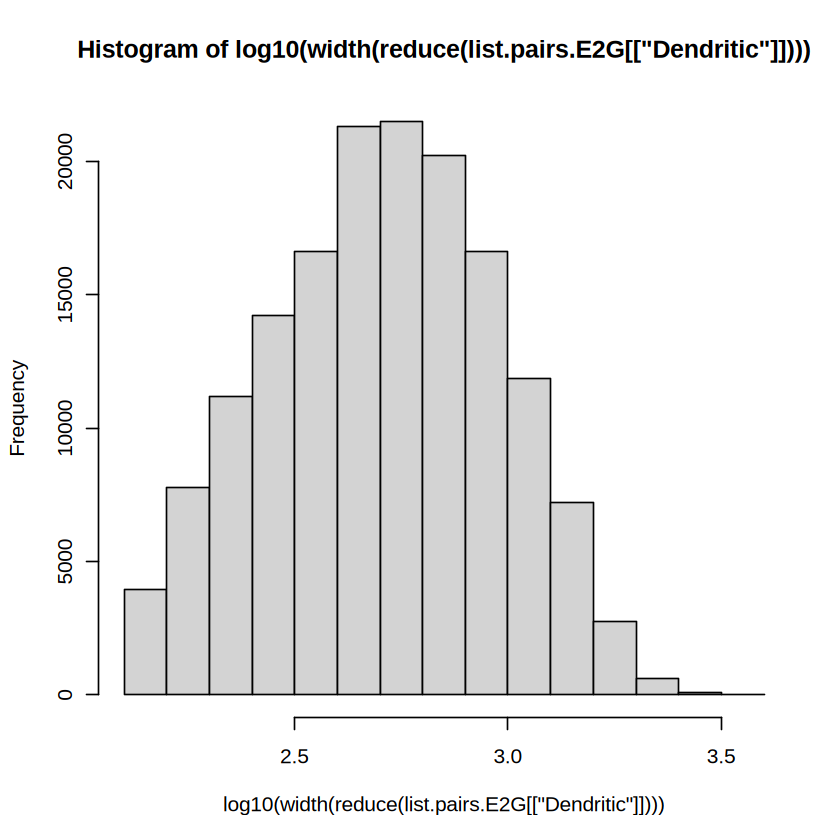

In [14]:
hist(log10(width(reduce(list.pairs.E2G[["Dendritic"]]))))

Merge peaks

In [16]:
bed.peaks = reduce(unlist(as(list.pairs.E2G, "GRangesList")))
bed.peaks

GRanges object with 305522 ranges and 0 metadata columns:
           seqnames              ranges strand
              <Rle>           <IRanges>  <Rle>
       [1]     chr1         10010-10512      *
       [2]     chr1       115495-115916      *
       [3]     chr1       180477-181904      *
       [4]     chr1       191243-191960      *
       [5]     chr1       267886-268118      *
       ...      ...                 ...    ...
  [305518]     chrX 156008487-156008683      *
  [305519]     chrX 156008873-156009316      *
  [305520]     chrX 156019835-156020122      *
  [305521]     chrX 156029840-156030373      *
  [305522]     chrX 156030498-156030725      *
  -------
  seqinfo: 23 sequences from an unspecified genome; no seqlengths

Make E-G pairs

In [17]:
pair.ABC.1M = unlist(as(list.ABC.1M, "GRangesList"))

In [18]:
overlaps.res = findOverlaps(bed.peaks,
                            pair.ABC.1M)

In [19]:
pairs.peak_gene = bed.peaks[overlaps.res@from]
mcols(pairs.peak_gene)[,"TargetGene"] = mcols(pair.ABC.1M)[overlaps.res@to,"TargetGene"]
mcols(pairs.peak_gene)[,"PeakName"] = 
  paste(seqnames(pairs.peak_gene),
        start(pairs.peak_gene),
        end(pairs.peak_gene),
        sep = "-")

In [20]:
mcols(pairs.peak_gene)[,"PairName"] = 
  paste(mcols(pairs.peak_gene)[,"PeakName"],
        mcols(pairs.peak_gene)[,"TargetGene"],
        sep = "_")
pairs.peak_gene = pairs.peak_gene[order(mcols(pairs.peak_gene)[,"PairName"])]
pairs.peak_gene = pairs.peak_gene[!duplicated(mcols(pairs.peak_gene)[,"PairName"])]
pairs.peak_gene

GRanges object with 5716549 ranges and 3 metadata columns:
            seqnames              ranges strand |  TargetGene
               <Rle>           <IRanges>  <Rle> | <character>
        [1]     chr1 100015450-100016026      * |         AGL
        [2]     chr1 100015450-100016026      * |      CDC14A
        [3]     chr1 100015450-100016026      * |         DBT
        [4]     chr1 100015450-100016026      * |       EXTL2
        [5]     chr1 100015450-100016026      * |     MFSD14A
        ...      ...                 ...    ... .         ...
  [5716545]     chrX     9995615-9996434      * |        WWC3
  [5716546]     chrX     9997010-9998101      * |       CLCN4
  [5716547]     chrX     9997010-9998101      * |     SHROOM2
  [5716548]     chrX     9997010-9998101      * |       TBL1X
  [5716549]     chrX     9997010-9998101      * |        WWC3
                          PeakName               PairName
                       <character>            <character>
        [1] chr1-10

Generate peak x cell matrix

In [21]:
bed.peaks.matrix = reduce(pairs.peak_gene)
bed.peaks.matrix

GRanges object with 303482 ranges and 0 metadata columns:
           seqnames              ranges strand
              <Rle>           <IRanges>  <Rle>
       [1]     chr1         10010-10512      *
       [2]     chr1       115495-115916      *
       [3]     chr1       180477-181904      *
       [4]     chr1       191243-191960      *
       [5]     chr1       267886-268118      *
       ...      ...                 ...    ...
  [303478]     chrX 156008487-156008683      *
  [303479]     chrX 156008873-156009316      *
  [303480]     chrX 156019835-156020122      *
  [303481]     chrX 156029840-156030373      *
  [303482]     chrX 156030498-156030725      *
  -------
  seqinfo: 23 sequences from an unspecified genome; no seqlengths

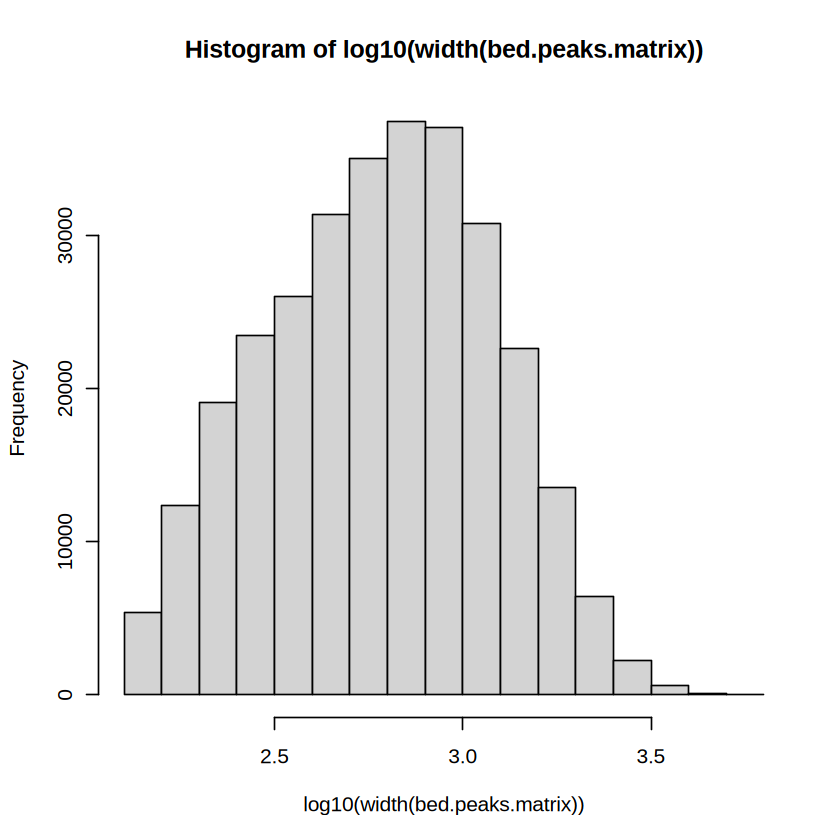

In [22]:
hist(log10(width(bed.peaks.matrix)))

Generate ATAC matrix

In [23]:
future::plan("multicore", workers = 32)
atac.matrix <- FeatureMatrix(
  fragments = obj.seurat@assays$ATAC_empty@fragments,
  features = bed.peaks.matrix,
  cells = colnames(obj.seurat@assays$RNA$counts)
)
future::plan("sequential")

Extracting reads overlapping genomic regions

Extracting reads overlapping genomic regions

Extracting reads overlapping genomic regions

Extracting reads overlapping genomic regions

Extracting reads overlapping genomic regions

Extracting reads overlapping genomic regions

Extracting reads overlapping genomic regions

Extracting reads overlapping genomic regions

Extracting reads overlapping genomic regions

Extracting reads overlapping genomic regions

Extracting reads overlapping genomic regions

Extracting reads overlapping genomic regions

Extracting reads overlapping genomic regions



In [24]:
obj.seurat[["ATAC"]] <- CreateChromatinAssay(
  counts = atac.matrix,
  fragments = obj.seurat@assays$ATAC_empty@fragments
)
DefaultAssay(obj.seurat) <- "ATAC"

In [25]:
obj.seurat <- obj.seurat %>%
  RunTFIDF() %>%
  FindTopFeatures(min.cutoff = 'q0') %>%
  RunSVD() %>%
  RunUMAP(reduction = 'lsi', dims = 2:30)

Performing TF-IDF normalization

Running SVD

Scaling cell embeddings

Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”
12:43:30 UMAP embedding parameters a = 0.9922 b = 1.112

Found more than one class "dist" in cache; using the first, from namespace 'spam'

Also defined by ‘BiocGenerics’

12:43:30 Read 69249 rows and found 29 numeric columns

12:43:30 Using Annoy for neighbor search, n_neighbors = 30

Found more than one class "dist" in cache; using the first, from namespace 'spam'

Also defined by ‘BiocGenerics’

12:43:30 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*


Warning message:
“ggrepel: 6 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


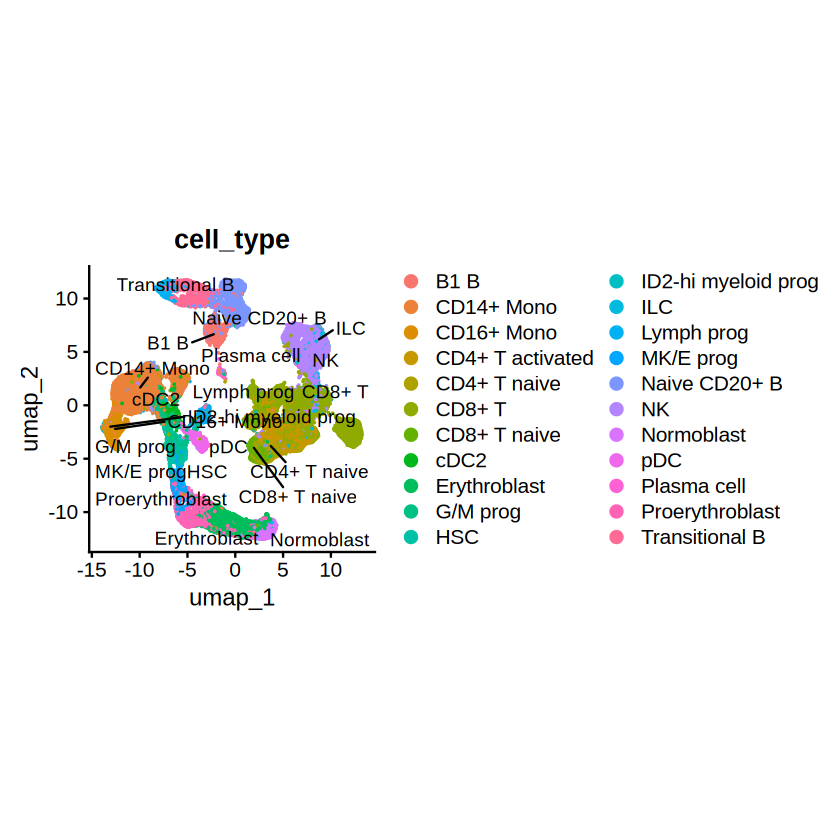

In [28]:
p = DimPlot(obj.seurat, 
        group.by = "cell_type",
        label = TRUE, 
        repel = TRUE, 
        reduction = "umap")  +
  theme(aspect.ratio=1)
p
ggsave("../../../output/BMMC/1.prepare_data/5.merge_peaks_from_5_super_groups.240524/UMAP.ATAC.cell_type.pdf", 
       plot = p, 
       width = 10, height = 8)

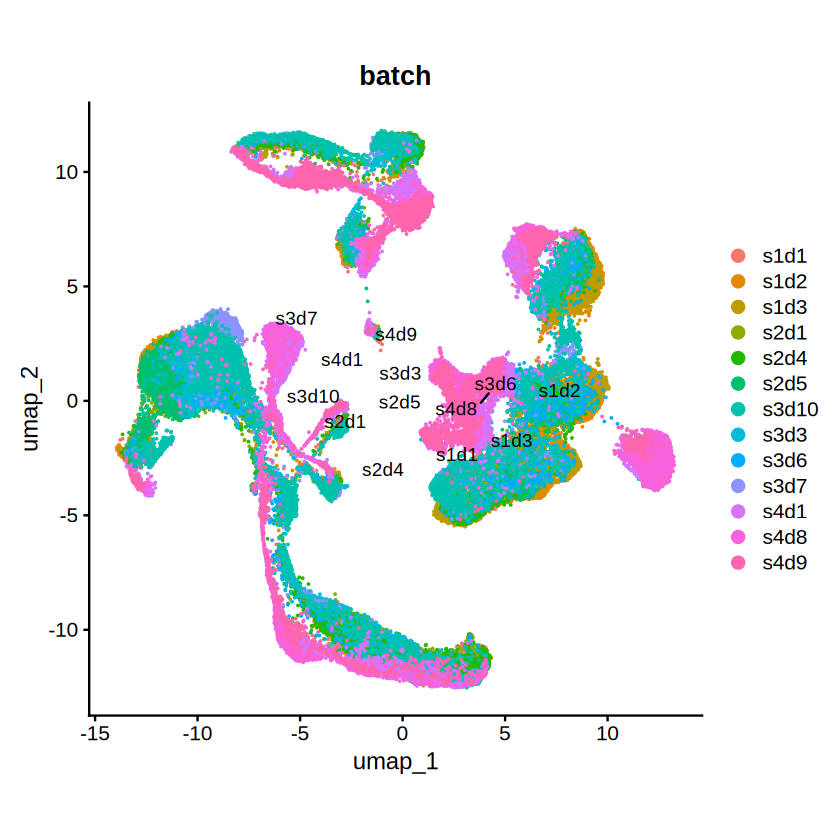

In [29]:
p = DimPlot(obj.seurat, 
        group.by = "batch",
        label = TRUE, 
        repel = TRUE, 
        reduction = "umap")  +
  theme(aspect.ratio=1)
p
ggsave("../../../output/BMMC/1.prepare_data/5.merge_peaks_from_5_super_groups.240524/UMAP.ATAC.batch.pdf", 
       plot = p, 
       width = 10, height = 8)

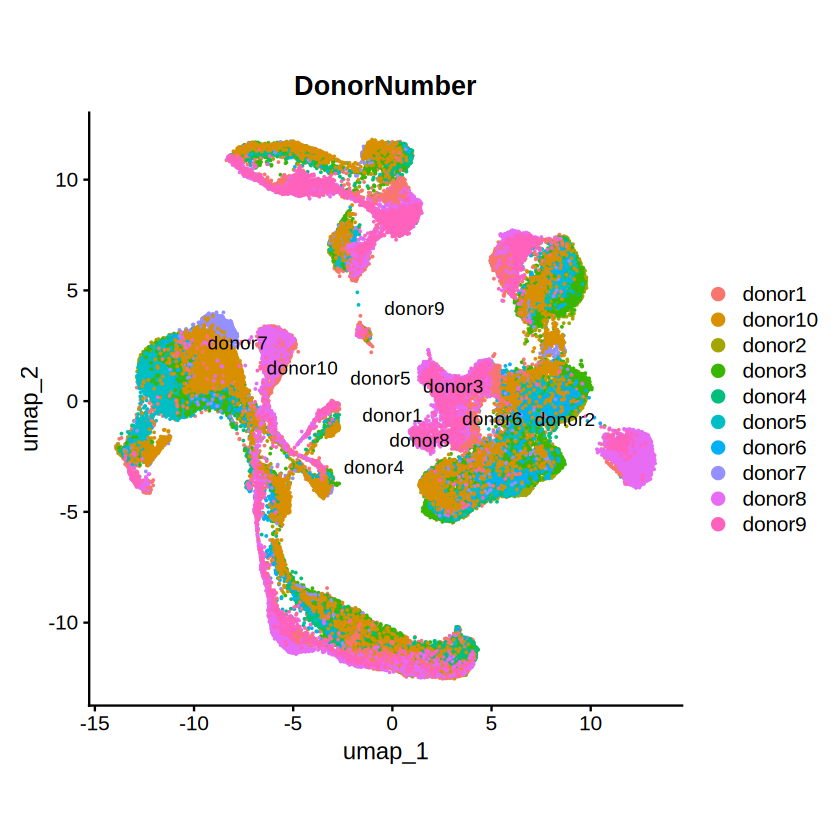

In [30]:
p = DimPlot(obj.seurat, 
        group.by = "DonorNumber",
        label = TRUE, 
        repel = TRUE, 
        reduction = "umap")  +
  theme(aspect.ratio=1)
p
ggsave("../../../output/BMMC/1.prepare_data/5.merge_peaks_from_5_super_groups.240524/UMAP.ATAC.DonorNumber.pdf", 
       plot = p, 
       width = 10, height = 8)

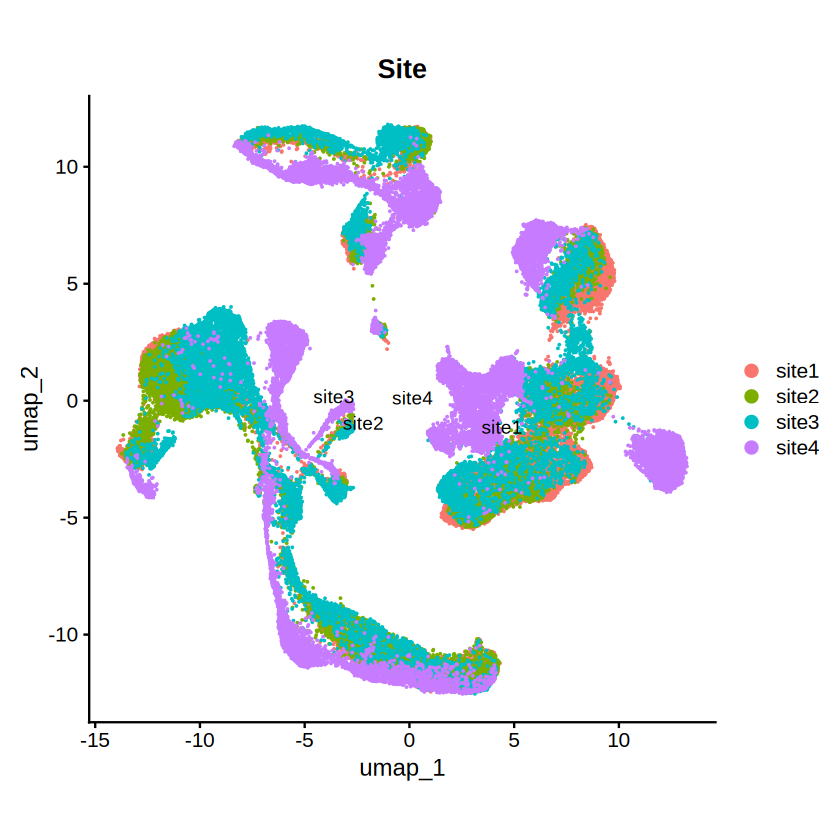

In [31]:
p = DimPlot(obj.seurat, 
        group.by = "Site",
        label = TRUE, 
        repel = TRUE, 
        reduction = "umap")  +
  theme(aspect.ratio=1)
p
ggsave("../../../output/BMMC/1.prepare_data/5.merge_peaks_from_5_super_groups.240524/UMAP.ATAC.Site.pdf", 
       plot = p, 
       width = 10, height = 8)

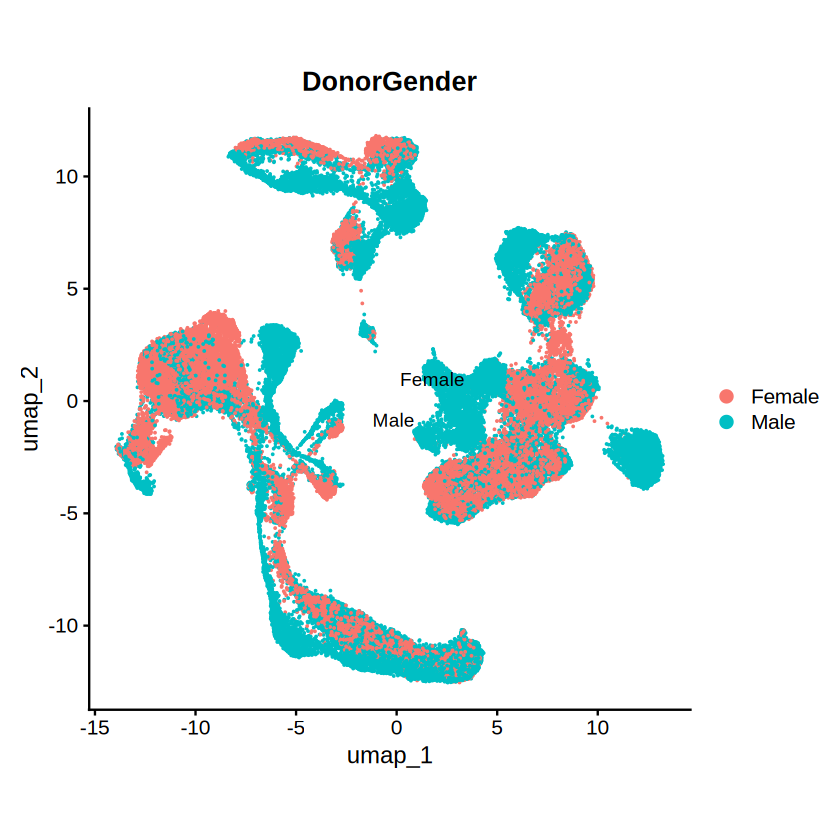

In [32]:
p = DimPlot(obj.seurat, 
        group.by = "DonorGender",
        label = TRUE, 
        repel = TRUE, 
        reduction = "umap")  +
  theme(aspect.ratio=1)
p
ggsave("../../../output/BMMC/1.prepare_data/5.merge_peaks_from_5_super_groups.240524/UMAP.ATAC.DonorGender.pdf", 
       plot = p, 
       width = 10, height = 8)

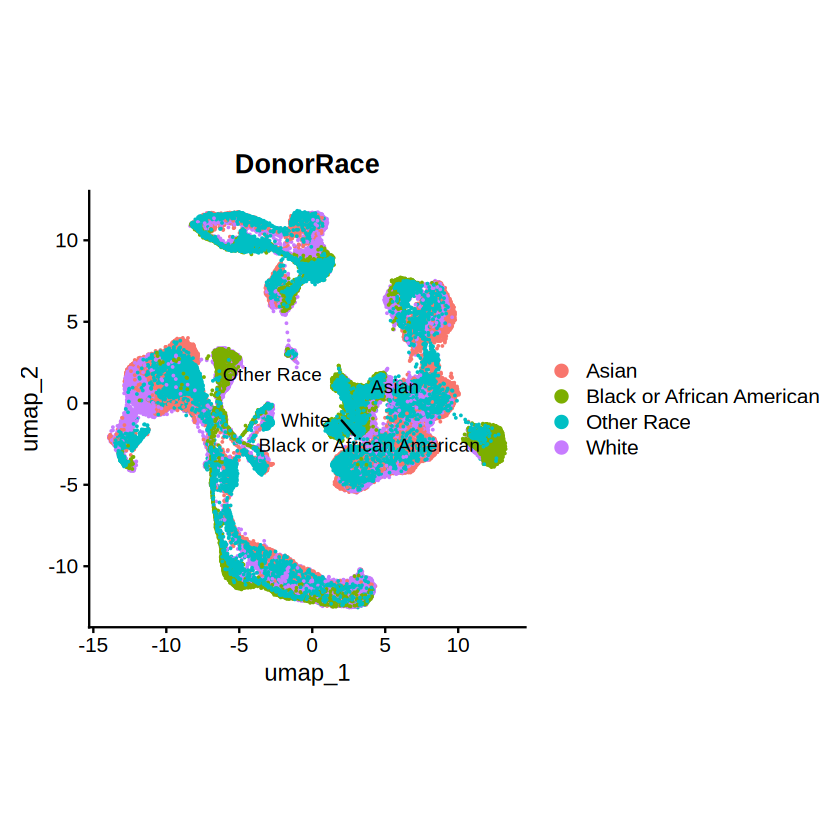

In [33]:
p = DimPlot(obj.seurat, 
        group.by = "DonorRace",
        label = TRUE, 
        repel = TRUE, 
        reduction = "umap")  +
  theme(aspect.ratio=1)
p
ggsave("../../../output/BMMC/1.prepare_data/5.merge_peaks_from_5_super_groups.240524/UMAP.ATAC.DonorRace.pdf", 
       plot = p, 
       width = 10, height = 8)

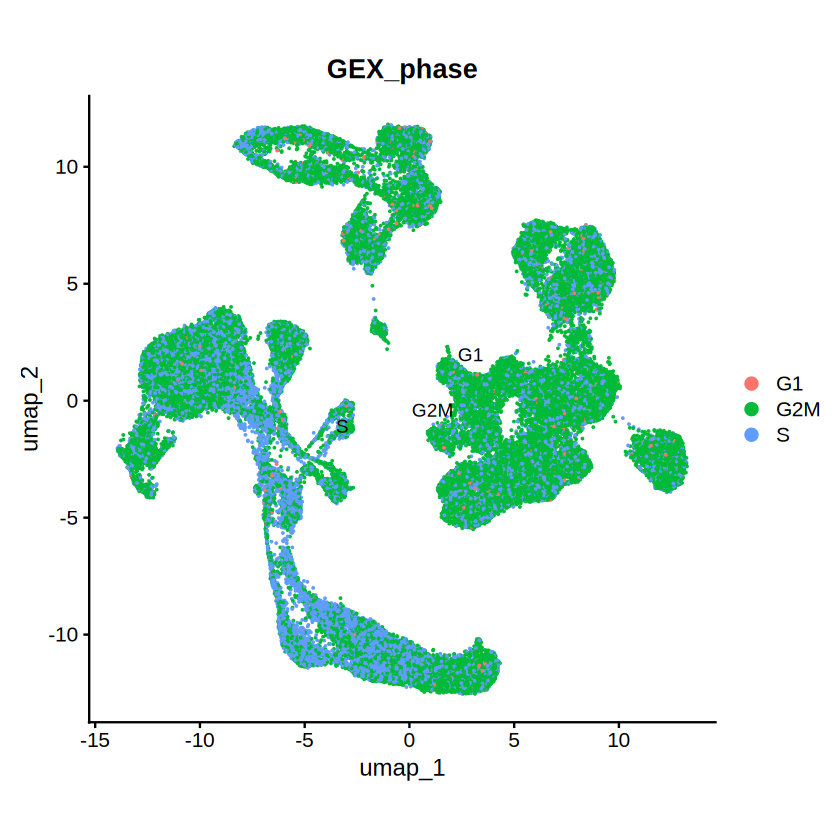

In [34]:
p = DimPlot(obj.seurat, 
        group.by = "GEX_phase",
        label = TRUE, 
        repel = TRUE, 
        reduction = "umap")  +
  theme(aspect.ratio=1)
p
ggsave("../../../output/BMMC/1.prepare_data/5.merge_peaks_from_5_super_groups.240524/UMAP.ATAC.GEX_phase.pdf", 
       plot = p, 
       width = 10, height = 8)

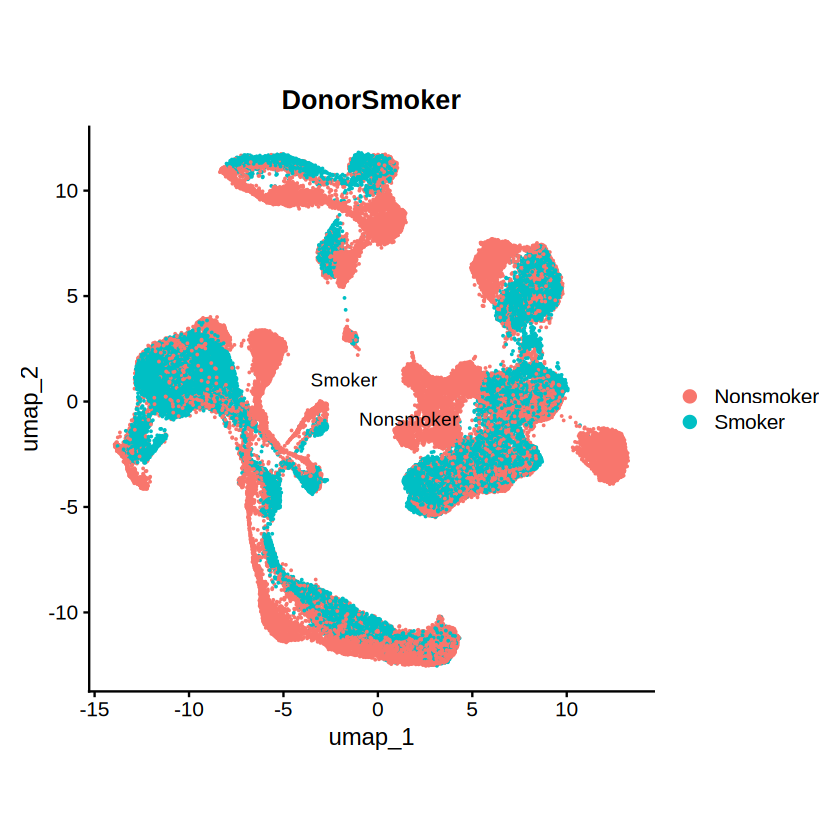

In [35]:
p = DimPlot(obj.seurat, 
        group.by = "DonorSmoker",
        label = TRUE, 
        repel = TRUE, 
        reduction = "umap")  +
  theme(aspect.ratio=1)
p
ggsave("../../../output/BMMC/1.prepare_data/5.merge_peaks_from_5_super_groups.240524/UMAP.ATAC.DonorSmoker.pdf", 
       plot = p, 
       width = 10, height = 8)

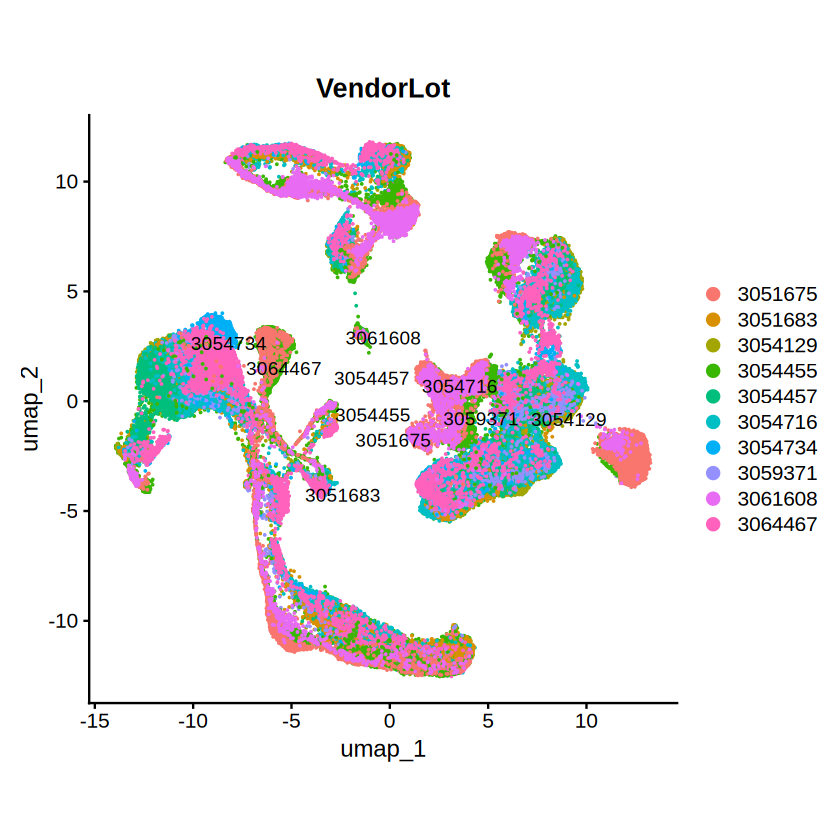

In [36]:
p = DimPlot(obj.seurat, 
        group.by = "VendorLot",
        label = TRUE, 
        repel = TRUE, 
        reduction = "umap")  +
  theme(aspect.ratio=1)
p
ggsave("../../../output/BMMC/1.prepare_data/5.merge_peaks_from_5_super_groups.240524/UMAP.ATAC.VendorLot.pdf", 
       plot = p, 
       width = 10, height = 8)

Save data

In [37]:
saveRDS(obj.seurat,
        paste(dir.output, "obj.seurat.rds", sep = "/"))

In [38]:
saveRDS(obj.seurat@assays$RNA$counts,
        paste(dir.output, "matrix.rna.rds", sep = "/"))

In [39]:
saveRDS(obj.seurat@assays$ATAC$counts,
        paste(dir.output, "matrix.atac.rds", sep = "/"))

In [40]:
saveRDS(pairs.peak_gene,
        paste(dir.output, "pairs.rds", sep = "/"))

In [45]:
saveRDS(obj.seurat@assays$RNA$counts[,!is.na(obj.seurat$cell_type.merged)],
        paste(dir.output, "matrix.rna.5_super_groups.rds", sep = "/"))

In [46]:
saveRDS(obj.seurat@assays$ATAC$counts[,!is.na(obj.seurat$cell_type.merged)],
        paste(dir.output, "matrix.atac.5_super_groups.rds", sep = "/"))

In [47]:
sessionInfo()

R version 4.3.3 (2024-02-29)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Red Hat Enterprise Linux 8.9 (Ootpa)

Matrix products: default
BLAS/LAPACK: /maps/projects/ralab/people/lpm537/software/anaconda3/envs/Notebook_E2G_240505/lib/libopenblasp-r0.3.27.so;  LAPACK version 3.12.0

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

time zone: Europe/Copenhagen
tzcode source: system (glibc)

attached base packages:
[1] stats4    grid      stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] ggplot2_3.5.1        Matrix_1.6-5         GenomicRanges_1.54.1
 [4] GenomeInfoDb_1.38.1  IRanges_2.36.0       S4Vectors_0.40.2    

In [3]:
matrix.atac.5_super_groups = readRDS("/maps/projects/ralab_nnfc-AUDIT/people/lpm537/project/E2G/analysis/E2G_240503/data/BMMC/1.prepare_data/5.merge_peaks_from_5_super_groups.240524/matrix.atac.5_super_groups.rds")

In [ ]:
data.table::fwrite(as.data.frame(as.matrix(matrix.atac.5_super_groups)),
                   "/maps/projects/ralab_nnfc-AUDIT/people/lpm537/project/E2G/analysis/E2G_240503/data/BMMC/1.prepare_data/5.merge_peaks_from_5_super_groups.240524/matrix.atac.5_super_groups.csv.gz",
                   row.names = T)